In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
train = pd.read_csv('./data/train_transformed.csv')
X_test = pd.read_csv('./data/test_transformed.csv')

X_train = train.drop('SalePrice',axis=1)
y_train = train.SalePrice

#X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# adding missing 1-hot encoded columns so regression has same columns
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = False

# TODO fix.. just dropping this extra 1-hot encoded column that appeared in the test set
X_test.drop('MSSubClass_150',axis=1,inplace=True)

X_test = X_test[X_train.columns]


0.11504029543840721


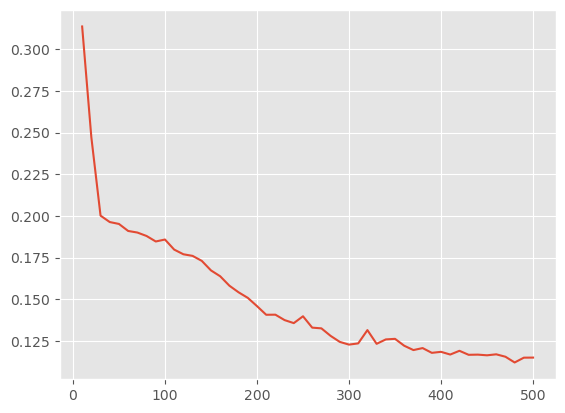

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import random

# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior on GPU (might impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Convert your pandas DataFrames to numeric NumPy arrays and then to tensors.
X_train_numeric = X_train.astype(np.float32)
y_train_numeric = y_train.astype(np.float32)
X_test_numeric  = X_test.astype(np.float32)

X_train_tensor = torch.tensor(X_train_numeric.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_numeric.to_numpy(), dtype=torch.float32).unsqueeze(1)
X_test_tensor  = torch.tensor(X_test_numeric.to_numpy(), dtype=torch.float32)

# Create a DataLoader for mini-batch training.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define a simple feed-forward neural network.
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output layer for regression
        )
    
    def forward(self, x):
        return self.net(x)

# Instantiate the model.
input_dim = X_train_tensor.shape[1]
model = FeedForwardNN(input_dim)

# Define the custom loss function: RMSE of log values.
def rmse_log_loss(pred, target, epsilon=1e-7):
    # Clamp predictions and targets to ensure positivity
    pred = torch.clamp(pred, min=epsilon)
    target = torch.clamp(target, min=epsilon)
    return torch.sqrt(torch.mean((torch.log(pred) - torch.log(target)) ** 2))

# Define the optimizer.
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = []
losses = []

# Training loop.
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()                # Clear gradients
        outputs = model(batch_X)               # Forward pass
        loss = rmse_log_loss(outputs, batch_y) # Compute custom loss
        loss.backward()                        # Backpropagation
        optimizer.step()                       # Update weights
        
        epoch_loss += loss.item() * batch_X.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    if (epoch + 1) % 10 == 0:
        #print(f"Epoch [{epoch+1}/{num_epochs}], RMSE Log Loss: {epoch_loss:.4f}")

        epochs.append(epoch+1)
        losses.append(epoch_loss)

'''
# Predict on the test set.
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    print("First five predictions:")
    print(predictions[:5])
'''
print()

plt.plot(epochs,losses)

print(losses[-1])

In [4]:
# Set the model to evaluation mode
model.eval()

# Predict on the test set without tracking gradients
with torch.no_grad():
    predictions = model(X_test_tensor)
    print("Predictions on X_test:")
    print(predictions)

nn_submission = pd.DataFrame()
nn_submission['Id'] = X_test['Id']
nn_submission['SalePrice'] = predictions

nn_submission.to_csv('submission-nn.csv',index=False)

Predictions on X_test:
tensor([[127700.7734],
        [171852.7656],
        [197446.3281],
        ...,
        [162636.6250],
        [135448.1094],
        [229203.6719]])
